In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pypfopt
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting
from pypfopt import EfficientFrontier, objective_functions
from pypfopt import HRPOpt
from RiskParityModel import *
#from MaxSharpe import *
from datetime import datetime,timedelta
from scipy.stats import norm
import json

In [2]:
with open('/Users/afraaa/portfolio/sector.json', 'r') as f:
    sector_dict = json.load(f)
with open('/Users/afraaa/portfolio/stock_sector.json', 'r') as f:
    stock_sector_dict = json.load(f)
add = '/Users/afraaa/portfolio/申万行业指数.xlsx'
sector_index = pd.read_excel(add,parse_dates=[0],index_col=0)

In [3]:
add = '/Users/afraaa/portfolio/market_cap.xlsx'
mcaps_df = pd.read_excel(add,parse_dates=[0],index_col=0)

In [4]:
add = '/Users/afraaa/portfolio/market_prices.xlsx'
market_prices_df = pd.read_excel(add,parse_dates=[0],index_col=0)

In [5]:
add= '/Users/afraaa/portfolio/prices.xlsx'
prices_df = pd.read_excel(add,parse_dates=[0],index_col=0)

In [6]:
def fill_value(df):
    mask = df.isna()
    df = df.interpolate()
    df = df.fillna(method='ffill')
    df = df.fillna(method='bfill')
    noise = np.random.uniform(low=-0.1, high=0.1, size=df.shape)
    noise = pd.DataFrame(noise, columns = df.columns)
    if not df[mask].empty: 
        df[mask] = df[mask].add(noise[mask])
    df = df.dropna()
    return df

In [7]:
def time_filter(df,start,end):
    temp = df.loc[(df.index >= start) & (df.index <= end)]
    return temp

In [8]:
def tail_prob(z):
    left_tail_prob = norm.cdf(z)
    right_tail_prob = 1 - left_tail_prob
    return min(left_tail_prob,right_tail_prob)

In [9]:
def calcu_mw_weights(ef):
    ef.add_objective(objective_functions.L2_reg)
    ef.max_sharpe(risk_free_rate=0)
    weights = ef.clean_weights()
    return weights

In [10]:
import numpy as np
from cvxopt import matrix, solvers

def max_sharpe_ratio(mu, Sigma, r_f=0.2):
    # Define variables for optimization problem
    n = len(mu)
    mu = mu.values
    ar = Sigma.values
    P = matrix(ar)
    q = matrix(np.zeros((n, 1)))
    G = matrix(np.concatenate((-mu.reshape(-1, 1), -np.eye(n)), axis=1))
    h = matrix(np.concatenate((np.array([-r_f]), np.zeros(n))))

    # Solve the optimization problem
    sol = solvers.qp(P, q, G.T, h)

    # Extract portfolio weights
    w = np.array(sol['x']).reshape(-1)

    return w/w.sum()

In [11]:
class portfolio_construction:
    def __init__(self, rebalance_time):
        self.rebalance_time = rebalance_time
        self.data_time = rebalance_time - timedelta(days=30)
        self.test_time = rebalance_time + timedelta(days=30)
        self.return_comparison = pd.DataFrame()
        self.tickers()
        self.mcaps()
        self.market_prices()
        self.prices()
        self.return_bl()
        self.weights()
        temp = self.return_bl_sec(self.market_prior,self.S)
        self.ret_sec = temp[0]
        self.S_sec = temp[1]
        temp = self.return_bl_sec(self.ret_bl,self.S_bl)
        self.ret_bl_sec = temp[0]
        self.S_bl_sec = temp[1]
    
    def tickers(self):
        tickers_temp = list(mcaps_df.loc[self.rebalance_time].dropna().index)
        
        temp = prices_df[tickers_temp]
        backward_prices = time_filter(temp,self.data_time,self.rebalance_time)
        df = backward_prices
        ratio = df.count()/len(df)
        selected_cols = ratio[ratio >= 0.68].index.tolist()

        temp = prices_df[selected_cols]
        forward_prices = time_filter(temp,self.rebalance_time,self.test_time)
        df = forward_prices
        ratio = df.count()/len(df)
        selected_cols = ratio[ratio >= 0.68].index.tolist()

        self.tickers = selected_cols
    
    def mcaps(self):
        self.mcaps = mcaps_df.loc[self.rebalance_time,self.tickers].to_dict()
    
    def market_prices(self):
        market_prices = time_filter(market_prices_df,self.data_time,self.rebalance_time)
        market_prices = market_prices.dropna()
        self.market_prices = market_prices
    
    def prices(self):
        temp = prices_df[self.tickers]
        forward_prices = time_filter(temp,self.rebalance_time,self.test_time)
        backward_prices = time_filter(temp,self.data_time,self.rebalance_time)
        self.forward_prices = forward_prices.interpolate()
        self.forward_prices.dropna(inplace=True)
        self.backward_prices = fill_value(backward_prices)
    
    def viewmatrix(self):
        df = self.forward_prices
        percent_change = (df.iloc[-1] - df.iloc[0]) / df.iloc[0] * 12
        change = (df.iloc[-1] - df.iloc[0]) 
        non_empty = percent_change.dropna().index
        confidences = (change.loc[non_empty] / 30 / df.std().loc[non_empty]).apply(tail_prob).tolist()
        df = percent_change.loc[non_empty]
        df += np.random.uniform(low=-0.1*df, high=0.1*df, size=df.shape)
        #viewdict = percent_change.loc[non_empty].to_dict()
        viewdict = df.to_dict()
        self.viewdict = viewdict
        self.confidences = confidences

    def return_bl(self):
        #S = risk_models.CovarianceShrinkage(self.backward_prices).ledoit_wolf()
        S = self.backward_prices.cov()
        delta = black_litterman.market_implied_risk_aversion(self.market_prices)
        delta = delta.item()
        market_prior = black_litterman.market_implied_prior_returns(self.mcaps, delta, S)
        self.viewmatrix()

        bl = BlackLittermanModel(S, 
            pi=market_prior, 
            absolute_views=self.viewdict, 
            omega="idzorek", 
            view_confidences=self.confidences,
            tau=1)

        ret_bl = bl.bl_returns()
        S_bl = bl.bl_cov()
        self.rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(self.viewdict)], 
             index=["Prior", "Posterior", "Views"]).T
        self.ret_bl = ret_bl
        self.S_bl = S_bl
        self.S = S
        self.market_prior = market_prior
        self.delta = delta
    
    def weights_ms(self):
        weights_bl_ms = max_sharpe_ratio(self.market_prior, self.S)
        weights_og_ms = max_sharpe_ratio(self.ret_bl, self.S_bl)
        weights_og_sec_ms = max_sharpe_ratio(self.ret_sec, self.S_sec)
        weights_bl_sec_ms = max_sharpe_ratio(self.ret_bl_sec, self.S_bl_sec)
        self.return_comparison['og_ms'] = (self.forward_prices*weights_og_ms).sum(axis=1)
        self.return_comparison['bl_ms'] = (self.forward_prices*weights_bl_ms).sum(axis=1)
        self.return_comparison['og_sec_ms'] = (self.forward_prices*weights_og_sec_ms).sum(axis=1)
        self.return_comparison['bl_sec_ms'] = (self.forward_prices*weights_bl_sec_ms).sum(axis=1)

    '''
    def weights_mw(self):
    待写
        ef_og = EfficientFrontier(self.market_prior, self.S)
        ef_bl = EfficientFrontier(self.ret_bl, self.S_bl)
        weights_bl_mw = calcu_mw_weights(ef_bl)
        weights_og_mw = calcu_mw_weights(ef_og)
        self.return_comparison['og_mw'] = (self.forward_prices*weights_og_mw).sum(axis=1)
        self.return_comparison['bl_mw'] = (self.forward_prices*weights_bl_mw).sum(axis=1)
    '''
    
    '''
    def weights_hrp(self):
    待写
        hrp_og = HRPOpt(self.market_prior)
        hrp_bl = HRPOpt(self.ret_bl)
        hrp_og.optimize()
        hrp_bl.optimize()
        weights_og_hrp = hrp_og.clean_weights()
        weights_bl_hrp = hrp_bl.clean_weights()
        return_comparison['og_hrp'] = (self.forward_prices*weights_og_hrp).sum(axis=1)
        return_comparison['bl_hrp'] = (self.forward_prices*weights_bl_hrp).sum(axis=1)
    '''
    
    def weights_rp(self):
        weights_og_rp = risk_parity_model(self.S,self.tickers)
        weights_bl_rp = risk_parity_model(self.S_bl,self.tickers) 
        weights_og_sec_rp = risk_parity_model(self.S_sec,self.tickers) 
        weights_bl_sec_rp = risk_parity_model(self.S_bl_sec,self.tickers) 
        self.return_comparison['og_rp'] = (self.forward_prices*weights_og_rp).sum(axis=1)
        self.return_comparison['bl_rp'] = (self.forward_prices*weights_bl_rp).sum(axis=1)
        self.return_comparison['og_sec_rp'] = (self.forward_prices*weights_og_sec_rp).sum(axis=1)
        self.return_comparison['bl_sec_rp'] = (self.forward_prices*weights_bl_sec_rp).sum(axis=1)


    def weights(self):
        n = len(self.tickers)
        weights_eq = [1/n] * n
        self.return_comparison['eq'] = (self.forward_prices*weights_eq).sum(axis=1)
    
    def sector_view(self):
        sec_view_dict = {}
        sec_confidences_list = []
        count = 0
        for ticker in self.tickers:
            try:
                sec = sector_dict[ticker]
                cor = stock_sector_dict[ticker]
                temp = time_filter(sector_index[sec],self.data_time,self.rebalance_time)
                value = (temp.iloc[-1] / temp.iloc[0]-1) * cor * 12
                sec_view_dict[ticker] = value
                temp = value / 360 / (self.backward_prices[ticker].std())
                confidence = tail_prob(temp)
                sec_confidences_list.append(confidence)
            except:
                print(ticker)
                count += 1
                continue       
        self.sec_view_dict = sec_view_dict
        self.sec_confidences_list = sec_confidences_list
    
    def return_bl_sec(self,market_prior,S):
        delta = self.delta
        self.sector_view()

        bl = BlackLittermanModel(S, 
            pi=market_prior, 
            absolute_views=self.sec_view_dict, 
            omega="idzorek", 
            view_confidences=self.sec_confidences_list,
            tau=1)

        return (bl.bl_returns(),bl.bl_cov())
        

In [12]:
#mf = portfolio_construction(datetime.strptime('2020-01','%Y-%m'))

In [13]:
#mf.tickers

In [14]:
#mf.weights_rp()
#mf.weights_ms()

In [15]:
'''
mf.return_comparison.plot()
plt.legend()
plt.show()
'''

'\nmf.return_comparison.plot()\nplt.legend()\nplt.show()\n'

In [16]:
record = []
start_date = datetime(2018, 4, 1)
end_date = datetime(2023, 1, 1)
current_date = start_date
while current_date < end_date:
    try:
        current_date_str = current_date.strftime('%Y-%m')
        pf = portfolio_construction(datetime.strptime(current_date_str,'%Y-%m'))
        pf.weights_ms()
        #pf.weights_rp()
        df = pf.return_comparison.drop(pf.return_comparison[(pf.return_comparison == 0).any(axis=1)].index)
        '''
        if current_date == start_date:
            record.append(pf.return_comparison/pf.return_comparison.iloc[0,:])
        else:
            record.append(pf.return_comparison/pf.return_comparison.iloc[0,:]*record[-1].iloc[-1,:])
        current_date += timedelta(days=30)
        '''
        if current_date == start_date:
            record.append(df/df.iloc[0,:])
        else:
            record.append(df/df.iloc[0,:]*record[-1].iloc[-1,:])
        current_date += timedelta(days=30)

    except:
        current_date += timedelta(days=30)
        print("An exception occurred regarding",current_date_str,". Skipping to the next iteration.")
        continue


     pcost       dcost       gap    pres   dres
 0:  3.1150e-03 -1.3423e-01  4e+02  2e+01  3e+01
 1:  5.6535e-02 -4.7689e+01  3e+02  2e+01  2e+01
 2:  2.6840e-01 -4.9671e+01  2e+02  1e+01  1e+01
 3:  6.4807e-01 -9.1656e+01  2e+02  1e+01  1e+01
 4:  3.9022e-01 -9.5846e+01  1e+02  5e+00  6e+00
 5:  7.0611e-05 -4.7813e+00  5e+00  2e-01  2e-01
 6:  7.1429e-09 -4.8234e-02  5e-02  2e-03  2e-03
 7:  7.6163e-13 -4.8237e-04  5e-04  2e-05  2e-05
 8:  1.5402e-13 -4.8237e-06  5e-06  2e-07  2e-07
 9:  6.7468e-13 -4.8256e-08  5e-08  2e-09  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  4.3317e-03 -2.9063e-01  4e+02  2e+01  2e+01
 1:  6.1465e-02 -5.0870e+01  4e+02  2e+01  1e+01
 2:  3.8722e-01 -5.2159e+01  2e+02  1e+01  1e+01
 3:  4.5055e-01 -9.5451e+01  2e+02  1e+01  9e+00
 4:  1.4793e-01 -7.9778e+01  1e+02  3e+00  3e+00
 5:  2.4773e-05 -1.9933e+00  2e+00  6e-02  6e-02
 6:  2.4799e-09 -2.0001e-02  2e-02  6e-04  6e-04
 7:  1.6834e-12 -2.0001e-04  2e-04  6e-06  6e-0

In [17]:
df = pd.concat(record)

In [18]:
pf.viewdict

{'000009.SZ': -0.8782259312087606,
 '000012.SZ': -0.9030609757642126,
 '000021.SZ': -1.0285040459737675,
 '000027.SZ': 0.4302725749374925,
 '000031.SZ': -1.027208083676534,
 '000039.SZ': -0.6338662244078428,
 '000050.SZ': -0.7549749288649787,
 '000060.SZ': -0.4648352616240621,
 '000062.SZ': 0.5566372601482134,
 '000089.SZ': 0.8664140506640778,
 '000155.SZ': -1.7616466455022017,
 '000156.SZ': 0.1374325102779448,
 '000400.SZ': -0.8372983461751535,
 '000401.SZ': -0.5633369336107834,
 '000402.SZ': -1.6836115801568863,
 '000415.SZ': -0.5924787645266656,
 '000513.SZ': -1.7012745700847982,
 '000519.SZ': -1.3400778103519522,
 '000537.SZ': -1.0915490561531094,
 '000540.SZ': -1.3148369414326837,
 '000547.SZ': -1.1322285856840844,
 '000553.SZ': -0.7691103814163321,
 '000559.SZ': -0.7574242967174167,
 '000563.SZ': -0.6738464439464686,
 '000581.SZ': -0.3567086368764016,
 '000591.SZ': -0.2659806557979215,
 '000598.SZ': -0.38496313334816995,
 '000623.SZ': -0.5703031242470035,
 '000629.SZ': -1.9402751

In [19]:
import seaborn as sns

In [20]:
import matplotlib.pyplot as plt

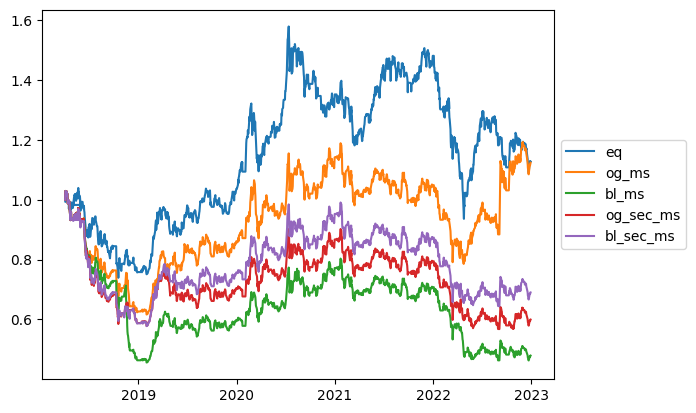

In [21]:
colors = plt.cm.tab10(np.linspace(0, 1, 10))[:9]
#colors = plt.cm.Dark2(np.concatenate((np.linspace(0, 1, 8), np.linspace(0, 1, 8))))[:9]
#colors = plt.cm.magma(np.linspace(0, 1, 9))

# Create a plot with 9 lines
fig, ax = plt.subplots()
for i, col in enumerate(df.columns):
    ax.plot(df.index, df[col], color=colors[i], label=col)

# Add a legend to the plot
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Adjust the plot to move it to the left
plt.subplots_adjust(left=0.1)

# Show the plot
plt.show()